# Using `spelunker` to study JWST Time Series Observations (TSOs)

---
**Authors:** Néstor Espinoza (nespinoza@stsci.edu), Derod Deal (dealderod@ufl.edu)  | **Last update:** Apr 16, 2024

**Program version:** ver. 0.5.3

JWST Time Series Observations (TSOs) are multi-integration exposures typically targetted at exploring time-varying phenomena: from exoplanetary transits to accreeting material in distant objects. Guidestar data such as the one `spelunker` can query can become very helpful at exploring this data; this tutorial provides an introduction on how to use the `spelunker` products to analyze it.

# 1. The case of HAT-P-14b NIRISS/SOSS observations

The first dataset we will be analyzing below comes from an exoplanetary transit obtained by [Program ID 1541](https://www.stsci.edu/jwst/science-execution/program-information?id=1541) (PI: Espinoza). This dataset was already introduced in [Albert et al. (2023)](https://arxiv.org/abs/2306.04572), and consisted of a transit observation of the exoplanet HAT-P-14~b, which was used to test the sensitivity and stability of the NIRISS/SOSS instrument during commissioning.  

To start the analysis, let's load some libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import spelunker

### 1.1 Exploring the transit event of HAT-P-14b

Let's first load and plot the NIRISS/SOSS HAT-P-14~b data:

In [2]:
t, f, ferr = np.loadtxt('hp14_lightcurve.dat', unpack = True, usecols = (0,1,2))

(0.0, 6.09976451843977)

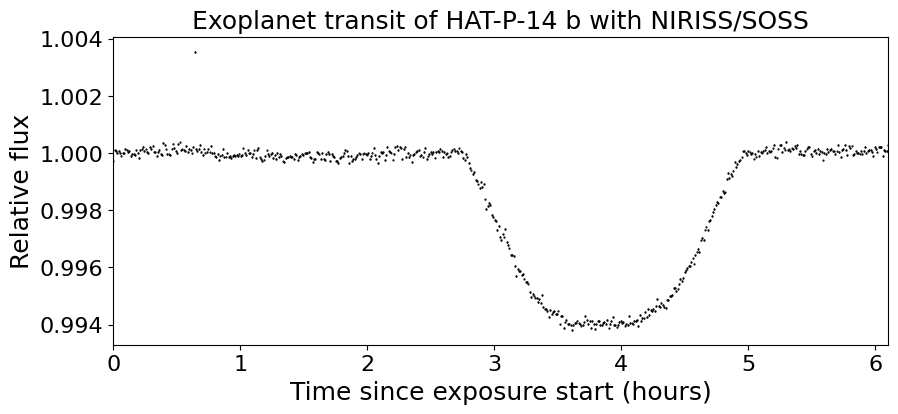

In [3]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.title('Exoplanet transit of HAT-P-14 b with NIRISS/SOSS', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

All right. This time-series shows a nice transit event from about hour 2.5 since exposure start, all the way until about hour 5. Aside from the transit event, however, there is an evident oscillation in the data, which is evident if we do a zoom to the first three hours of data:

(-500.0, 500.0)

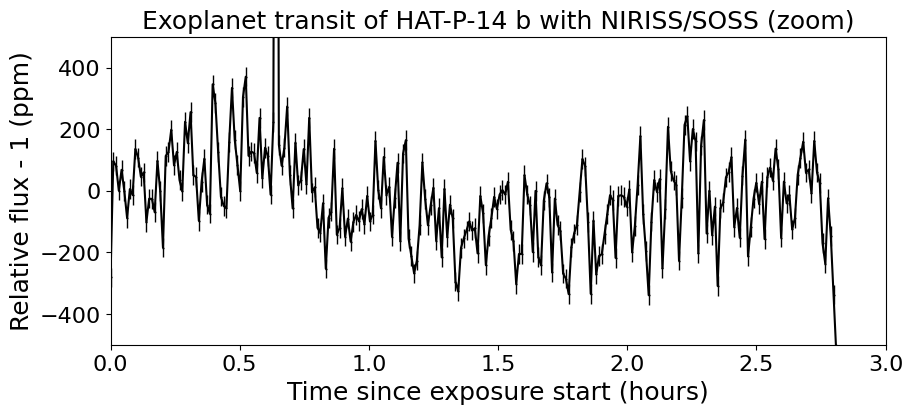

In [4]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.plot(time_since_start, (f-1)*1e6, color = 'black')
plt.errorbar(time_since_start, (f-1)*1e6, ferr*1e6, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.title('Exoplanet transit of HAT-P-14 b with NIRISS/SOSS (zoom)', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux - 1 (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), 3)
plt.ylim(-500, 500)

The light curve has at least two oscillation patterns. One is a long-term one, on which the light curve seems to rise at about hour 0.5 after start, then go down until about hour 1, and then oscillate up again at about hour 3. The other is a short-frequency oscillation, with a period of about ~5 minutes. The amplitude of those oscillations is small --- around 200 ppm.

Big question is: are those oscillations really happening on HAT-P-14 (the star)? Or is this an instrumental effect? Let's now explore the guidestar data to find this out.

### 1.2 Exploring the guidestar data of PID 1541

Let's use `spelunker` to load the guidestar data for this Program ID/observation/visit:

In [5]:
spk = spelunker.load(pid=1541, obs_num='1', visit='1', save=True)

Current working directory for spelunker: /Users/nespinoza/github/JWST-FGS-Spelunker/notebooks/spelunker_outputs

Connecting with astroquery...


Let's check the time-series of the guidestar data:

(0.0, 6.09976451843977)

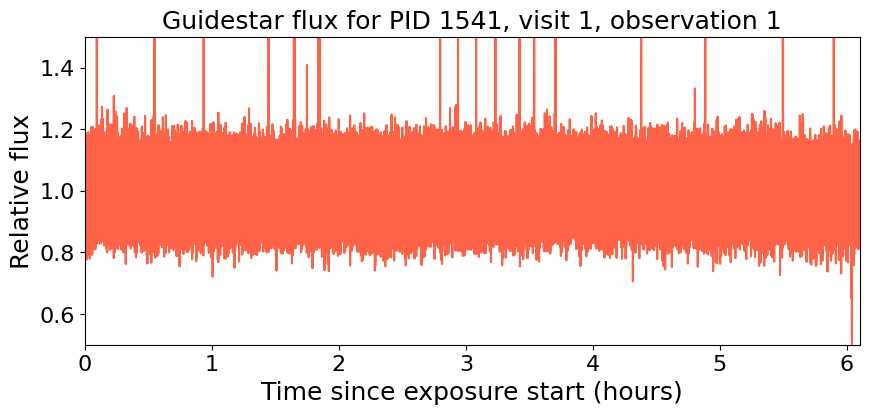

In [6]:
plt.figure(figsize=(10,4))

fg_time_since_start = (spk.fg_time + 2400000.5 - tstart) * 24

plt.plot(fg_time_since_start, spk.fg_flux / np.nanmedian( spk.fg_flux ) , color = 'tomato')

plt.title('Guidestar flux for PID 1541, visit 1, observation 1', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.ylim(0.5,1.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

The raw photometry from the guidestar varies by a lot more than our target star. Let's bin the FGS time-series to the same cadence as the science time-series. To this end, let's write a function that does this: 

In [7]:
def bin_fgs_to_science(tscience, tfgs, ffgs):
    """
    This function bins an FGS time-series defined by the times `tfgs` and fluxes `ffgs`, to times `tscience`. 
    The function assumes that (1) `tscience` are times obtained at pseudo-regular intervals (i.e., that times 
    on `tscience` next to each other are similar), and that (2) `tscience` is ordered in chronological order.
    """

    nscience = len(tscience)
    binned_fgs = np.zeros( nscience )
    binned_fgs_err = np.zeros( nscience )
    for i in range( nscience ):

        if i == 0:

            dt = tscience[1] - tscience[0] 

        elif i == nscience - 1:

            dt = tscience[-1] - tscience[-2]

        else:

            dt1 = tscience[i] - tscience[i-1]
            dt2 = tscience[i+1] - tscience[i]
            dt = ( dt1 + dt2 ) * 0.5
            
        idx = np.where( np.abs(tscience[i] - tfgs) < 0.5*dt )[0]
        binned_fgs[i] = np.mean( ffgs[idx] )
        binned_fgs_err[i] = np.sqrt( np.var( ffgs[idx] ) ) / np.sqrt( len(idx) )

    return binned_fgs, binned_fgs_err

In [8]:
fbin, fbinerr = bin_fgs_to_science(time_since_start, fg_time_since_start, spk.fg_flux / np.nanmedian( spk.fg_flux ))

(0.0, 3.0)

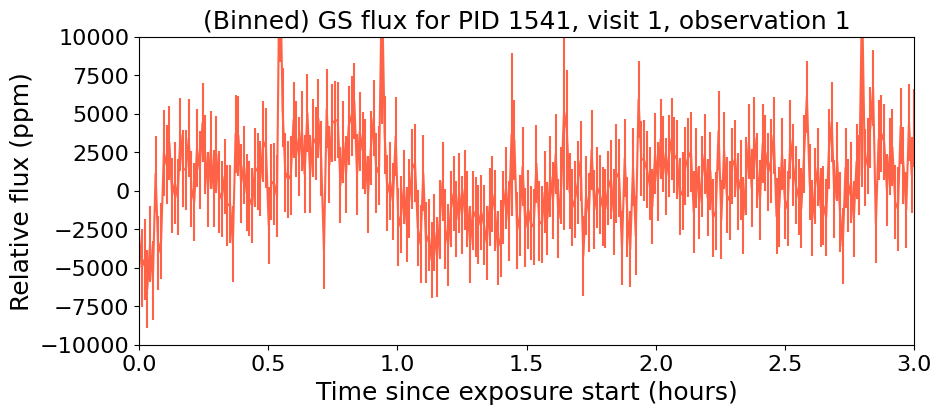

In [9]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, (fbin-1)*1e6, fbinerr*1e6, color = 'tomato')

plt.title('(Binned) GS flux for PID 1541, visit 1, observation 1', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux (ppm)', fontsize = 18)

plt.ylim(1.0-0.05,1+0.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(-10000, 10000)
plt.xlim(np.min(time_since_start), 3)

This actually resembles the science time-series quite nicely, although at a different amplitude. Let's plot both on the same figure:

(-500.0, 500.0)

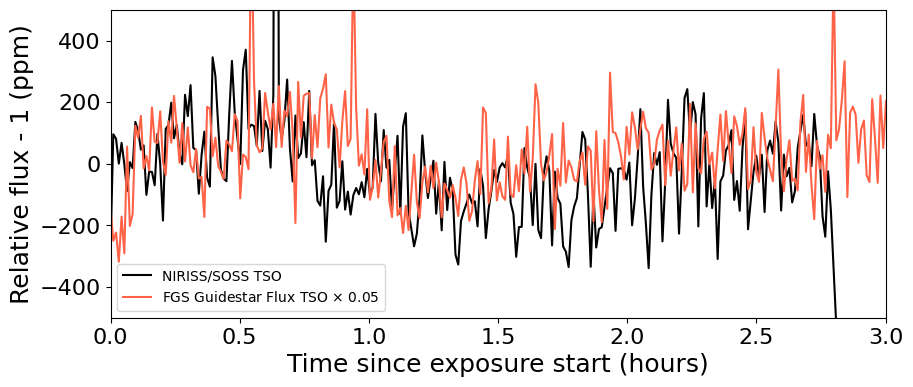

In [10]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.plot(time_since_start, (f-1)*1e6, color = 'black', label = 'NIRISS/SOSS TSO')

plt.plot(time_since_start, (fbin-1)*1e6*0.05, color = 'tomato', label = r'FGS Guidestar Flux TSO $\times$ 0.05')

plt.legend()
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux - 1 (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), 3)
plt.ylim(-500, 500)

Remarkable! The amplitude might need some tweaking, but it seems this can, indeed, help track some lightcurve variations. Let's look next at other features that could be correlated with instrumental systematics. 

### 1.3 More, more! Correlating PSF Guidestar properties to JWST TSOs

`spelunker` can also fit Gaussians to each of the 2D FG frames, and extract more precise parameters than the simple "crude" photometry described above. This takes a while (a few minutes), so we need to be a bit patient:

In [11]:
spk.gauss2d_fit(ncpus=4)

2023-07-28 15:06:29,069	ERROR services.py:1207 -- Failed to start the dashboard , return code 1
2023-07-28 15:06:29,072	ERROR services.py:1232 -- Error should be written to 'dashboard.log' or 'dashboard.err'. We are printing the last 20 lines for you. See 'https://docs.ray.io/en/master/ray-observability/ray-logging.html#logging-directory-structure' to find where the log file is.
2023-07-28 15:06:29,097	ERROR services.py:1276 -- 
The last 20 lines of /tmp/ray/session_2023-07-28_15-06-25_792862_10261/logs/dashboard.log (it contains the error message from the dashboard): 
2023-07-28 15:06:28,974	INFO head.py:226 -- Loading DashboardHeadModule: <class 'ray.dashboard.modules.usage_stats.usage_stats_head.UsageStatsHead'>
2023-07-28 15:06:28,974	INFO head.py:239 -- Loaded 1 modules. [<ray.dashboard.modules.usage_stats.usage_stats_head.UsageStatsHead object at 0x106db63a0>]
2023-07-28 15:06:28,974	INFO head.py:331 -- http server disabled.
2023-07-28 15:06:28,974	ERROR head.py:346 -- Failed to 

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float64,float64,float64,float64,float64,float64,float64
96.13580818091697,2.9489472302249555,2.8459489641612317,0.6615126270671262,0.5982857173004258,0.5084229861100592,1.0716251998893254
93.22999728230792,2.945971179314676,2.8321791067722404,0.6774501510971196,0.610760669468479,0.3324114335819944,0.7014456008012028
94.83739704115126,2.94180146636494,2.82125715177069,0.6799938081616088,0.6012986779279296,0.40859458291440265,0.6536850854022012
94.12867663693092,2.959077309637642,2.851779332482687,0.6862760348911927,0.5881373871809559,0.43462908400767114,1.193779403425883
95.09568324476194,2.9776655111309482,2.843257410088901,0.6745053368568955,0.5948537560303414,0.4436336278798898,0.6849093750054519
96.09149159005842,2.936042771168488,2.8397027851196017,0.6561865491418671,0.5921877323474933,0.31271186839202075,1.0385142236743439
...,...,...,...,...,...,...
87.74914558987756,2.6959405822169913,2.9659239812865574,0.7329552946836715,0.6397187407597072,0.4390018622237538,1.1684951454848664
90.59196412930257,2.692654629778445,2.988546762625284,0.7198071514645737,0.6515556783383257,0.4521983178189343,0.6256298448573007


In [12]:
results = {}

for key in list(spk.gaussfit_results.keys()):

    results[key], _ = bin_fgs_to_science(time_since_start, 
                                         fg_time_since_start, 
                                         spk.gaussfit_results[key].value)

In [13]:
print(results.keys())

dict_keys(['amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev', 'theta', 'offset'])


Let's plot all of those parameters for the entire duration of the TSO:

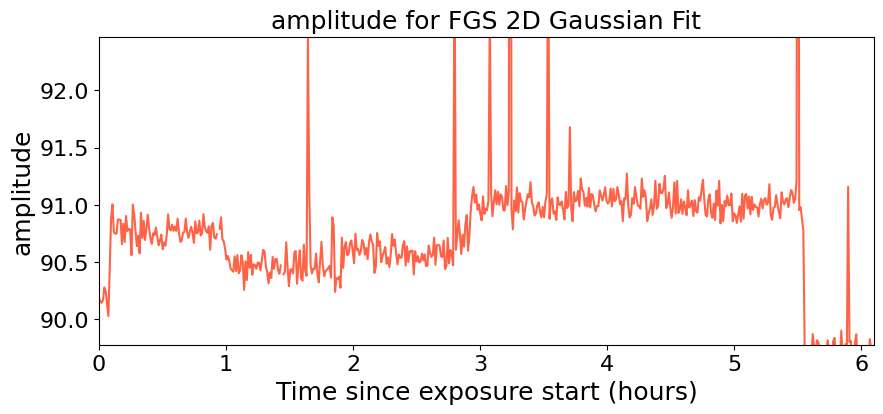

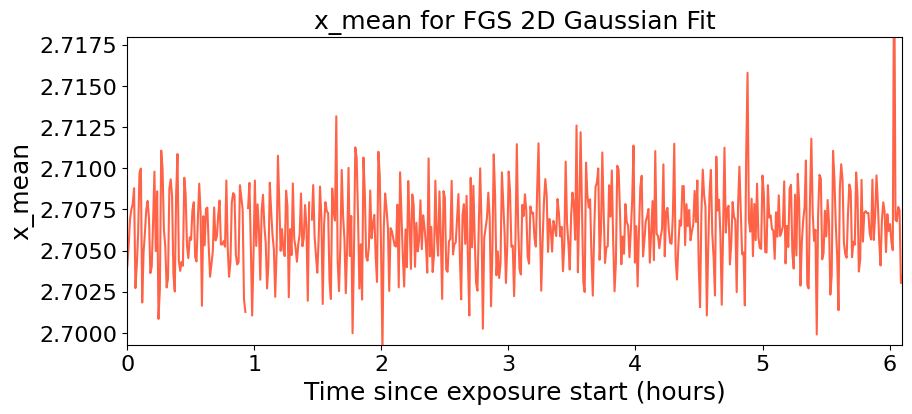

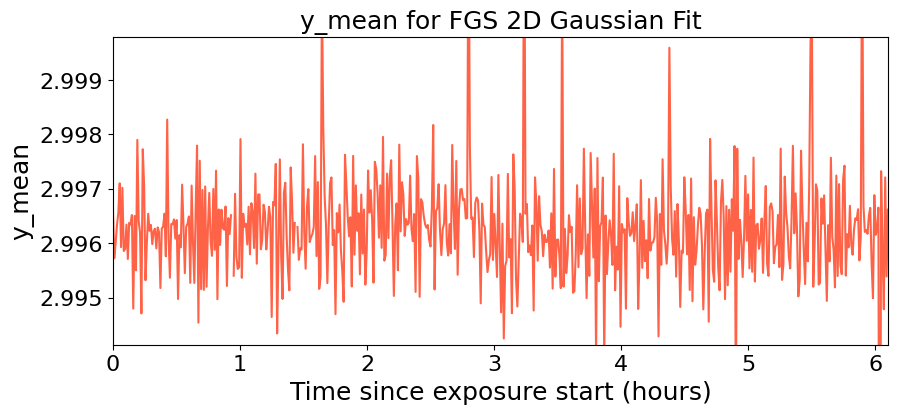

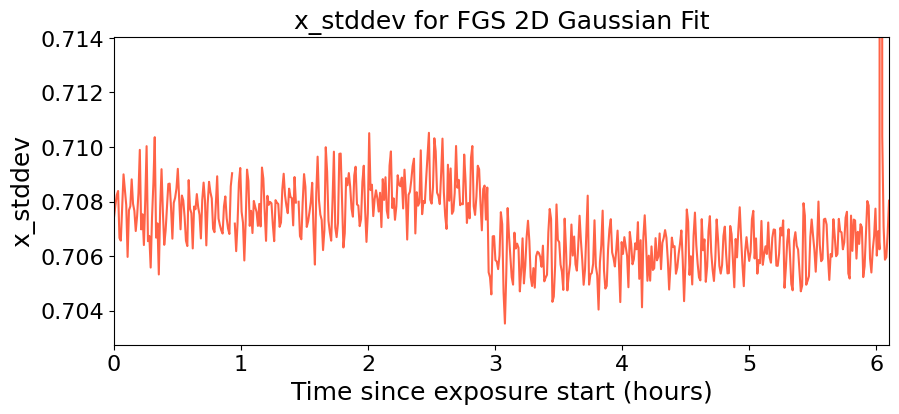

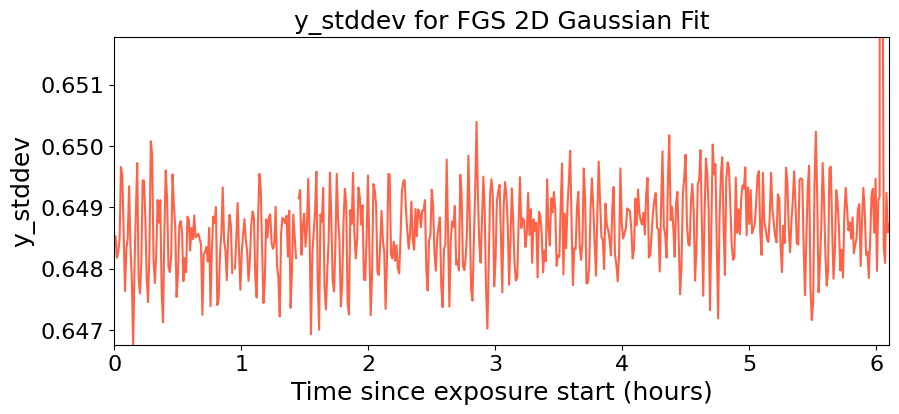

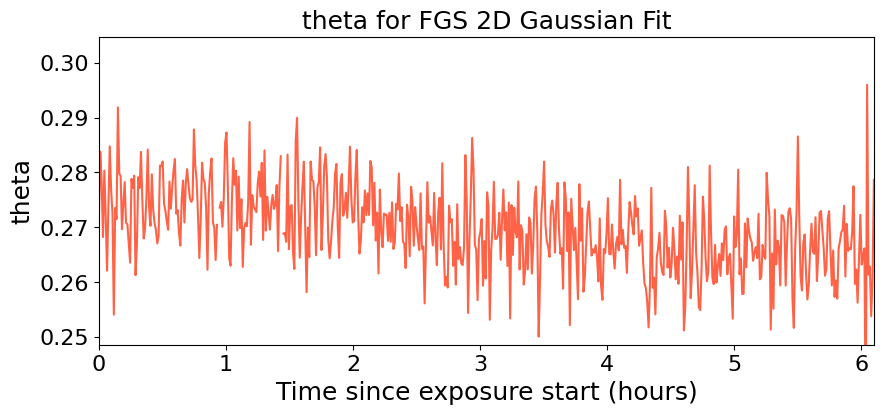

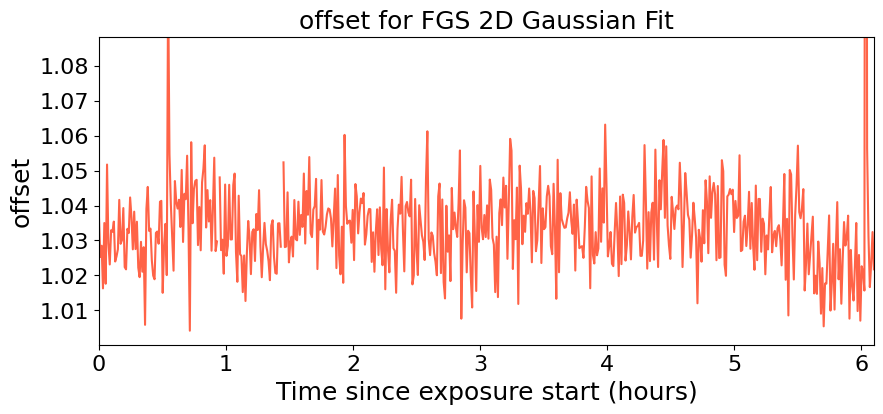

In [14]:
for key in list(results.keys()):

    plt.figure(figsize=(10,4))

    median = np.nanmedian(results[key])
    std = np.nanmedian(np.abs(results[key] - median)) * 1.4826
    plt.plot(time_since_start, results[key], color = 'tomato')
    
    plt.title(key+' for FGS 2D Gaussian Fit', fontsize = 18)
    plt.xlabel('Time since exposure start (hours)', fontsize = 18)
    plt.ylabel(key, fontsize = 18)
    
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    
    plt.xlim(np.min(time_since_start), np.max(time_since_start))
    plt.ylim(median-3*std,median+5*std)

Neat! Many things to unpack. 

First, note how the position in X (`x_mean`) and the standard deviation in this direction (`x_stddev`), together with the standard deviation on the y-direction (`y_stddev`) and the rotation angle of the gaussian (`theta`) all oscillate in short frequency, in concert with the science TSO. Let's compare those time-series on top of the science TSO for the first three hours. To do this, let's create a helper function that standarizes our regressors:

In [15]:
def standarize(x):

    median = np.nanmedian(x)
    std = np.nanmedian(np.abs(x - median)) * 1.4826    

    return ( x - median ) / std

(-500.0, 500.0)

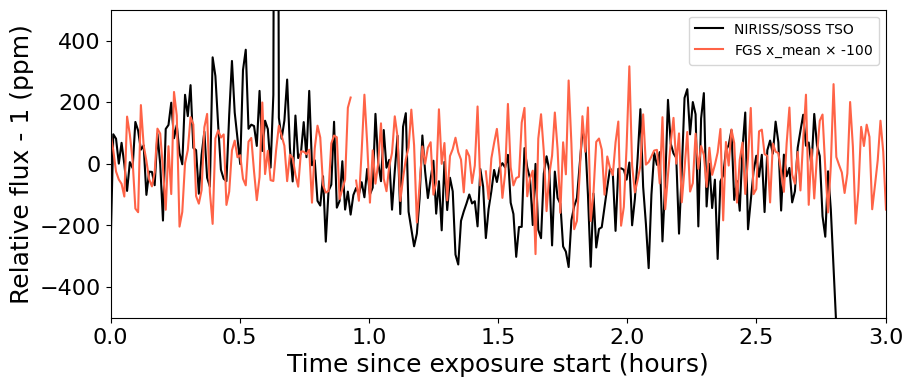

In [16]:
variable = 'x_mean'

plt.figure(figsize=(10,4))

plt.plot(time_since_start, (f-1)*1e6, color = 'black', label = 'NIRISS/SOSS TSO')

plt.plot(time_since_start, standarize(results[variable])*100*(-1), 
         color = 'tomato', label = r'FGS '+variable+r' $\times$ -100')

plt.legend()
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux - 1 (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), 3)
plt.ylim(-500, 500)

Very nice correlation between variables! Also, note how the x-standard deviation detects what appears to be a small tilt event:

(0.0, 6.09976451843977)

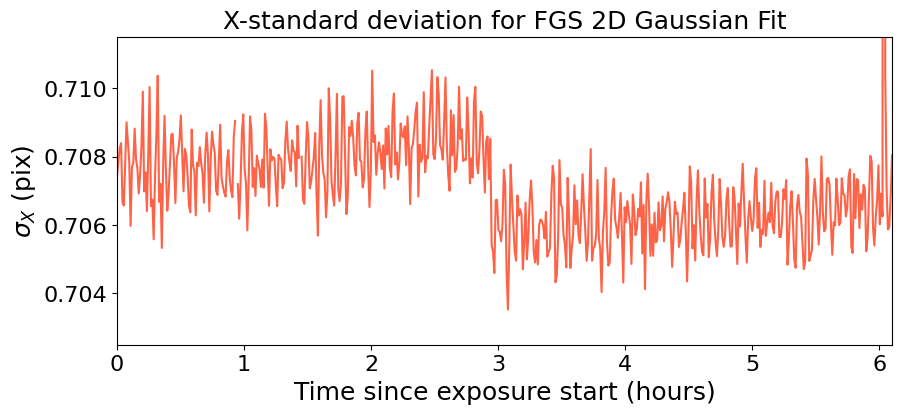

In [17]:
plt.figure(figsize=(10,4))

plt.plot(time_since_start, results['x_stddev'], color = 'tomato')
    
plt.title('X-standard deviation for FGS 2D Gaussian Fit', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('$\sigma_X$ (pix)', fontsize = 18)
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.7025,0.7115)
plt.xlim(np.min(time_since_start), np.max(time_since_start))

Seeing this from the actual TSO is quite difficult, because the tilt event happened _just_ during ingress:

(array([0.702, 0.704, 0.706, 0.708, 0.71 , 0.712]),
 [Text(1, 0.7020000000000001, '0.702'),
  Text(1, 0.7040000000000001, '0.704'),
  Text(1, 0.7060000000000001, '0.706'),
  Text(1, 0.7080000000000001, '0.708'),
  Text(1, 0.7100000000000001, '0.710'),
  Text(1, 0.7120000000000001, '0.712')])

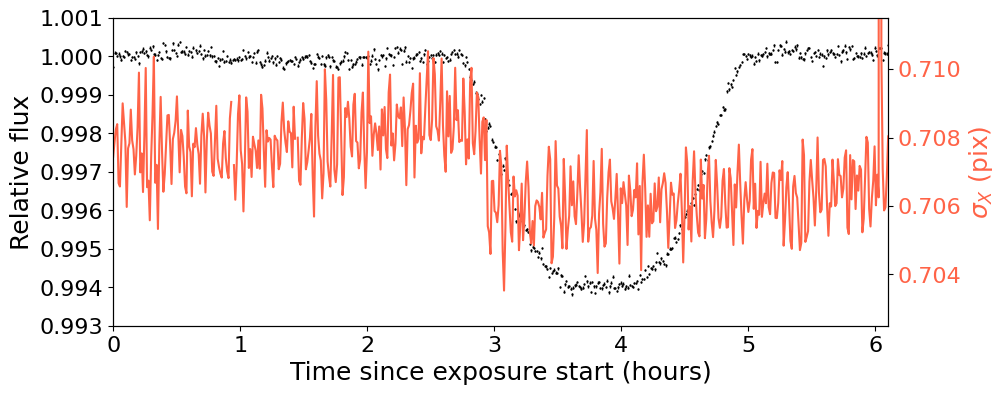

In [18]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(np.min(time_since_start), np.max(time_since_start))
plt.ylim(0.993, 1.001)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()
variable = 'x_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'tomato', label = r'FGS '+variable)

plt.ylim(0.7025,0.7115)

plt.ylabel('$\sigma_X$ (pix)', fontsize = 18, color = 'tomato')

plt.yticks(fontsize=16, color = 'tomato')

To showcase further the beauty of `spelunker` as a TSO event detector, let's analyze one more dataset on which the tilt event is obvious: the ERS observations of WASP-39 b with NIRSpec/G395H.

# 2. The case of WASP-39 b NIRSpec/G395H observations

Let's repeat the analysis for the transit WASP-39 b with NIRSpec/G395H. Let's study the NRS1 lightcurve presented in [Alderson et al. (2023)](https://www.nature.com/articles/s41586-022-05591-3):

In [22]:
t, f, ferr = np.loadtxt('w39_lightcurve.dat', unpack = True, usecols = (0,1,2))

(0.0, 8.256138402968645)

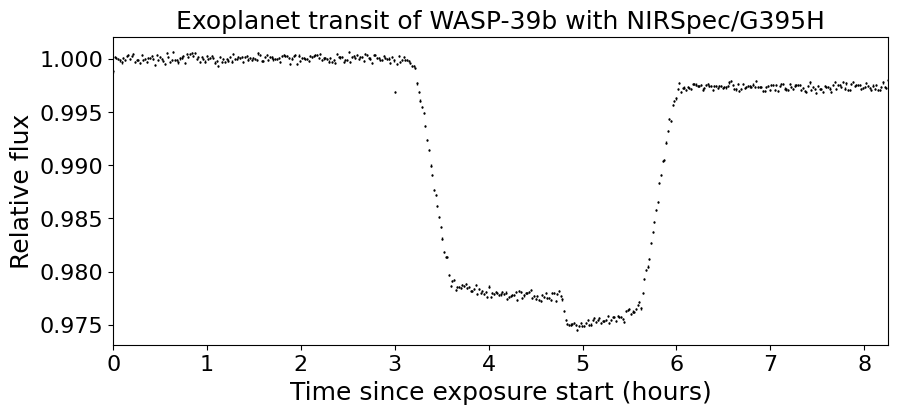

In [23]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.title('Exoplanet transit of WASP-39b with NIRSpec/G395H', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

Note that break in the transit light curve? That's a tilt event. One that `spelunker` can also detect! Let's run the `spelunker` magic for this program, which is [PID 1366 (PI: Batalha, co-PI: Bean, Stevenson)](https://www.stsci.edu/jwst/science-execution/program-information?id=1366). This, in particular, is observation number 3, visit 1:

In [24]:
spk = spelunker.load(pid=1366, obs_num='3', visit='1', save=True)

Current working directory for spelunker: /Users/nespinoza/github/JWST-FGS-Spelunker/notebooks/spelunker_outputs

Connecting with astroquery...


Let's explore the guidestar (binned) photometry:

In [25]:
fg_time_since_start = (spk.fg_time + 2400000.5 - tstart) * 24
fbin, fbinerr = bin_fgs_to_science(time_since_start, fg_time_since_start, spk.fg_flux / np.nanmedian( spk.fg_flux ))

(0.0, 8.256138402968645)

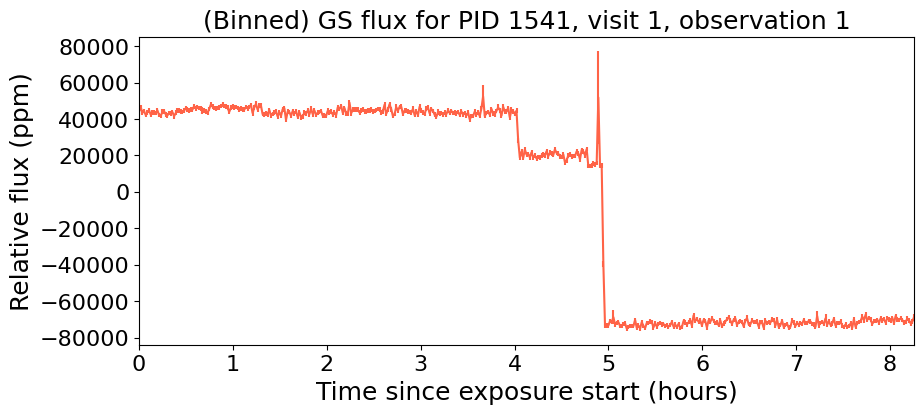

In [26]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, (fbin-1)*1e6, fbinerr*1e6, color = 'tomato')

plt.title('(Binned) GS flux for PID 1541, visit 1, observation 1', fontsize = 18)
plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux (ppm)', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

Oh my. It's not only one, but perhaps...two, three tilt events?:

(array([-100000.,  -80000.,  -60000.,  -40000.,  -20000.,       0.,
          20000.,   40000.,   60000.,   80000.,  100000.]),
 [Text(1, -100000.0, '−100000'),
  Text(1, -80000.0, '−80000'),
  Text(1, -60000.0, '−60000'),
  Text(1, -40000.0, '−40000'),
  Text(1, -20000.0, '−20000'),
  Text(1, 0.0, '0'),
  Text(1, 20000.0, '20000'),
  Text(1, 40000.0, '40000'),
  Text(1, 60000.0, '60000'),
  Text(1, 80000.0, '80000'),
  Text(1, 100000.0, '100000')])

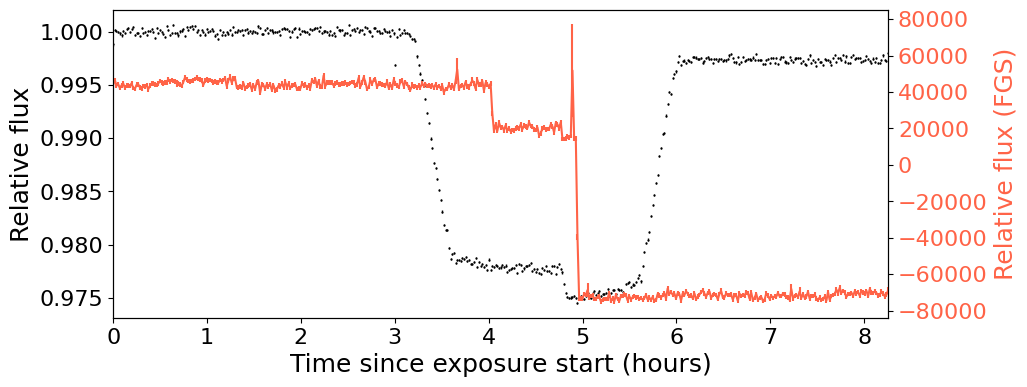

In [27]:
tstart = t[0]
time_since_start = (t-tstart)*24

plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.twinx()

plt.errorbar(time_since_start, (fbin-1)*1e6, fbinerr*1e6, color = 'tomato')

plt.ylabel('Relative flux (FGS)', fontsize = 18, color = 'tomato')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16, color = 'tomato')

Very interesting. Let's explore the gaussian fits to the data:

In [28]:
spk.gauss2d_fit(ncpus=4)

2023-07-28 15:30:48,400	ERROR node.py:605 -- Failed to connect to GCS. Please check `gcs_server.out` for more details.
2023-07-28 15:30:56,510	INFO worker.py:1621 -- Started a local Ray instance.
(raylet) [2023-07-28 15:31:35,478 E 11739 36386361] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-28_15-30-41_512027_10261 is over 95% full, available space: 26698432512; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) Failed to connect to GCS. Please check `gcs_server.out` for more details.
(raylet) Traceback (most recent call last):
(raylet)   File "/Users/nespinoza/opt/anaconda3/envs/newen/lib/python3.9/site-packages/ray/_private/workers/default_worker.py", line 229, in <module>
(raylet)     ray._private.worker.connect(
(raylet)   File "/Users/nespinoza/opt/anaconda3/envs/newen/lib/python3.9/site-packages/ray/_private/worker.py", line 2282, in connect
(raylet)     tracing_hook_val = worker.gcs_client.internal_kv_get(
(raylet)   File "pytho

(autoscaler +28m44s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +28m44s) Warning: The following resource request cannot be scheduled right now: {'CPU': 4.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet) [2023-07-28 15:32:05,491 E 11739 36386361] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-28_15-30-41_512027_10261 is over 95% full, available space: 26702692352; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2023-07-28 15:32:15,508 E 11739 36386361] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-28_15-30-41_512027_10261 is over 95% full, available space: 26704752640; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2023-07-28 15:32:25,516 E 11739 36386361] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-28_15-30-41_512027_10261 is over 95% full, available space: 26704728064; capacity: 994662584320. Object creation will fail if spilling is required.


(autoscaler +29m19s) Warning: The following resource request cannot be scheduled right now: {'CPU': 4.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(raylet) [2023-07-28 15:32:35,522 E 11739 36386361] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-28_15-30-41_512027_10261 is over 95% full, available space: 26705850368; capacity: 994662584320. Object creation will fail if spilling is required.
(raylet) [2023-07-28 15:32:40,621 E 11739 36386340] (raylet) worker_pool.cc:544: Some workers of the worker process(11906) have not registered within the timeout. The process is dead, probably it crashed during start.
(raylet) [2023-07-28 15:32:40,623 E 11739 36386340] (raylet) worker_pool.cc:544: Some workers of the worker process(11907) have not registered within the timeout. The process is dead, probably it crashed during start.
(raylet) [2023-07-28 15:32:40,623 E 11739 36386340] (raylet) worker_pool.cc:544: Some workers of the worker process(11908) have not registered within the timeout. The process is dead, probably it crashed during start.
(raylet) [2023-07-28 15:32:40,960 E 11739 36386340] (raylet) worker_pool.cc:544: Som

amplitude,x_mean,y_mean,x_stddev,y_stddev,theta,offset
float64,float64,float64,float64,float64,float64,float64
101.2130875542324,3.3337141869616698,3.1211539650536118,0.6455960581549347,0.6787948700644653,-0.9882345633774572,1.2600175942667253
103.05907718346985,3.33371710766348,3.142691936508253,0.6215190964749095,0.6992885770745251,8.421751880874677,0.4315062171942471
107.62423515840916,3.3329848169769485,3.120927859230632,0.6134283966398637,0.6706534574534939,2.1012697533767146,1.0340357839332834
105.13550772812634,3.340446149057725,3.1465417724009326,0.6194982306101161,0.6743140206939372,8.33284963100652,0.3417050813233455
105.81117632539961,3.3294497348834233,3.1567470988399315,0.687199451837556,0.619261893520507,-8.95975328933037,1.0360083315734216
106.22326098792206,3.317701776351794,3.1573008366804722,0.6732302628935715,0.6200459189744063,-2.6905026977639435,1.393730020315556
...,...,...,...,...,...,...
92.73785019284357,3.1873002094970913,3.7376647173565347,0.6696140357514423,0.6149201200291508,0.5719390312820085,0.7572221044577753
97.97532198761044,3.188108276531111,3.719662716727466,0.6720903777369073,0.6015700463433664,0.7071603924088367,1.2912940683375458


Let's bin this to the science time-stamps:

In [29]:
results = {}

for key in list(spk.gaussfit_results.keys()):

    results[key], _ = bin_fgs_to_science(time_since_start, 
                                         fg_time_since_start, 
                                         spk.gaussfit_results[key].value)

Let's go right away to the X standard deviation:

(array([0.662, 0.664, 0.666, 0.668, 0.67 , 0.672]),
 [Text(1, 0.662, '0.662'),
  Text(1, 0.664, '0.664'),
  Text(1, 0.666, '0.666'),
  Text(1, 0.668, '0.668'),
  Text(1, 0.67, '0.670'),
  Text(1, 0.672, '0.672')])

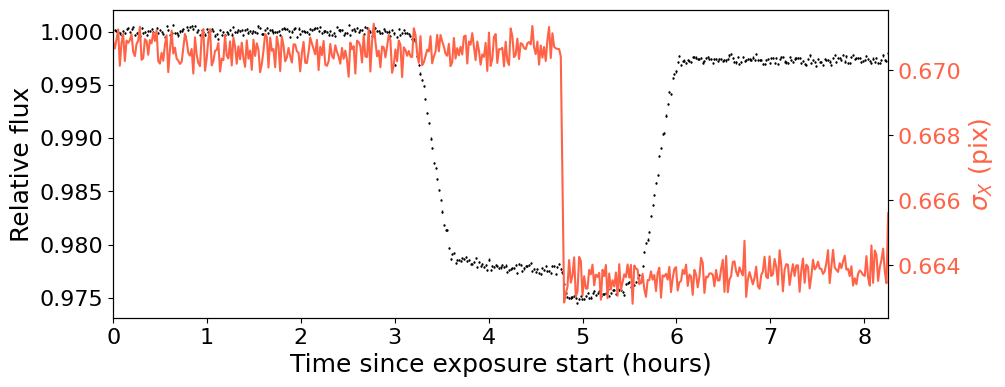

In [32]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = '.', 
                         ms = 1, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(np.min(time_since_start), np.max(time_since_start))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()
variable = 'x_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'tomato', label = r'FGS '+variable)

plt.ylabel('$\sigma_X$ (pix)', fontsize = 18, color = 'tomato')

plt.yticks(fontsize=16, color = 'tomato')

Very interesting! The "tilt" event is beautifully detected by the guidestar data. Best of all, we can see the event at any resolution we want thanks to it. Let's write a function that can bin the data at any temporal resolution so we can see this in action:

In [33]:
def bin_data(x,y,n_bin):
    
    x_bins = []
    y_bins = []
    y_err_bins = []
    
    for i in range(0,len(x),n_bin):
        
        x_bins.append(np.median(x[i:i+n_bin-1]))
        y_bins.append(np.median(y[i:i+n_bin-1]))
        y_err_bins.append(np.sqrt(np.var(y[i:i+n_bin-1]))/np.sqrt(len(y[i:i+n_bin-1])))
        
    return np.array(x_bins),np.array(y_bins),np.array(y_err_bins)

(array([0.66 , 0.662, 0.664, 0.666, 0.668, 0.67 , 0.672, 0.674, 0.676]),
 [Text(1, 0.66, '0.660'),
  Text(1, 0.662, '0.662'),
  Text(1, 0.664, '0.664'),
  Text(1, 0.666, '0.666'),
  Text(1, 0.668, '0.668'),
  Text(1, 0.67, '0.670'),
  Text(1, 0.672, '0.672'),
  Text(1, 0.674, '0.674'),
  Text(1, 0.676, '0.676')])

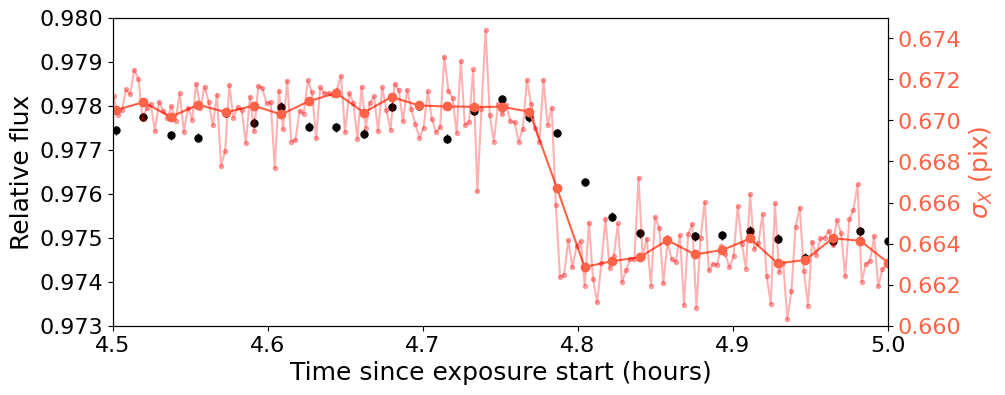

In [38]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = 'o', 
                         ms = 5, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(4.5,5.0)
plt.ylim(0.973, 0.980)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()

variable = 'x_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'tomato', label = r'FGS '+variable)

tbin, ybin, _ = bin_data((spk.fg_time + 2400000.5 - tstart) * 24, spk.gaussfit_results[variable].value, n_bin = 300)
plt.plot(tbin, ybin, '.-',
         color = 'red', alpha = 0.3)

plt.plot(time_since_start, results[variable], 
         'o', color = 'tomato')

plt.xlim(4.5,5.0)
plt.ylim(0.66,0.675)

plt.ylabel('$\sigma_X$ (pix)', fontsize = 18, color = 'tomato')

plt.yticks(fontsize=16, color = 'tomato')

Interestingly, in this case, the Y-standard deviation samples the event even better:

(array([0.58, 0.59, 0.6 , 0.61, 0.62, 0.63]),
 [Text(1, 0.5800000000000001, '0.58'),
  Text(1, 0.5900000000000001, '0.59'),
  Text(1, 0.6000000000000001, '0.60'),
  Text(1, 0.6100000000000001, '0.61'),
  Text(1, 0.6200000000000001, '0.62'),
  Text(1, 0.6300000000000001, '0.63')])

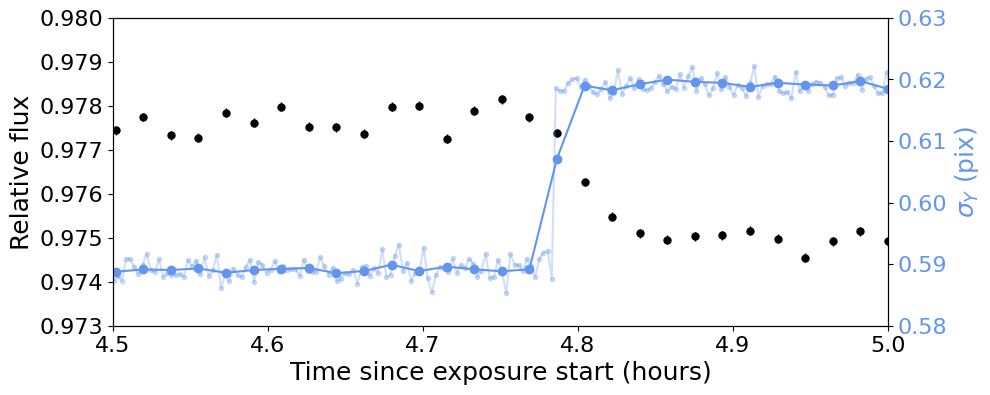

In [46]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = 'o', 
                         ms = 5, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(4.5,5.0)
plt.ylim(0.973, 0.980)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()

variable = 'y_stddev'
plt.plot(time_since_start, results[variable], 
         color = 'cornflowerblue', label = r'FGS '+variable)

tbin, ybin, _ = bin_data((spk.fg_time + 2400000.5 - tstart) * 24, spk.gaussfit_results[variable].value, n_bin = 300)
plt.plot(tbin, ybin, '.-',
         color = 'cornflowerblue', alpha = 0.3)

plt.plot(time_since_start, results[variable], 
         'o', color = 'cornflowerblue')

plt.xlim(4.5,5.0)
plt.ylim(0.58,0.63)

plt.ylabel('$\sigma_Y$ (pix)', fontsize = 18, color = 'cornflowerblue')

plt.yticks(fontsize=16, color = 'cornflowerblue')

It is very interesting how while the change of the PSF in the guidestar is almost instantaneous, the PSF change in the TSO is slightly smoother. This smooth behavior is actually quite nicely tracked by the mean positions:

(array([3.71 , 3.715, 3.72 , 3.725, 3.73 , 3.735, 3.74 ]),
 [Text(1, 3.71, '3.710'),
  Text(1, 3.715, '3.715'),
  Text(1, 3.72, '3.720'),
  Text(1, 3.725, '3.725'),
  Text(1, 3.73, '3.730'),
  Text(1, 3.735, '3.735'),
  Text(1, 3.74, '3.740')])

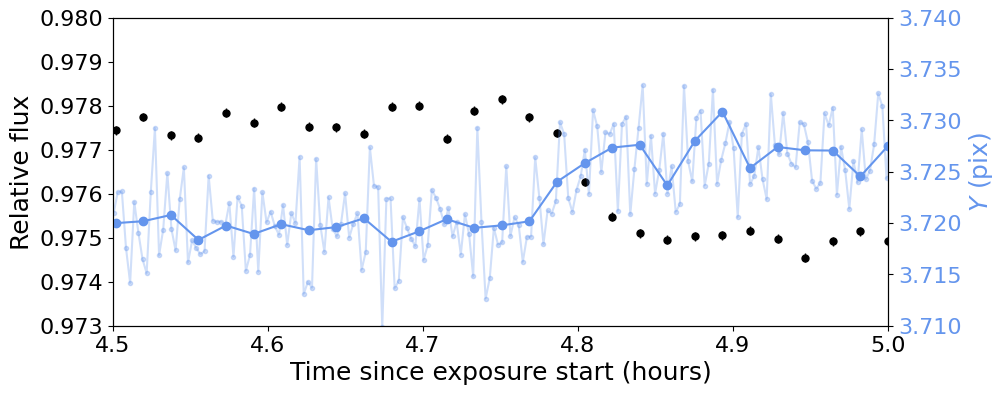

In [60]:
plt.figure(figsize=(10,4))

plt.errorbar(time_since_start, f, ferr, fmt = 'o', 
                         ms = 5, mfc = 'black', mec = 'black', 
                         elinewidth = 1, ecolor = 'black')

plt.xlabel('Time since exposure start (hours)', fontsize = 18)
plt.ylabel('Relative flux', fontsize = 18)


plt.xlim(4.5,5.0)
plt.ylim(0.973, 0.980)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.twinx()

variable = 'y_mean'
plt.plot(time_since_start, results[variable], 
         color = 'cornflowerblue', label = r'FGS '+variable)

tbin, ybin, _ = bin_data((spk.fg_time + 2400000.5 - tstart) * 24, spk.gaussfit_results[variable].value, n_bin = 300)
plt.plot(tbin, ybin, '.-',
         color = 'cornflowerblue', alpha = 0.3)

plt.plot(time_since_start, results[variable], 
         'o', color = 'cornflowerblue')

plt.xlim(4.5,5.0)
plt.ylim(3.71,3.74)

plt.ylabel('$Y$ (pix)', fontsize = 18, color = 'cornflowerblue')

plt.yticks(fontsize=16, color = 'cornflowerblue')